In [316]:
import tensorflow as tf
import numpy as np
from time import time
import matplotlib.pyplot as plt

In [317]:
# Set data type
DTYPE='float32'
tf.keras.backend.set_floatx(DTYPE)

In [318]:
# Define the parameters of the model
T = 1 # T = 1 at maturity
n = 50 # The number of trading days within a year 
dt = T/n # Define the time step size
increments = np.linspace(0, T, n + 1) # Define the time sequence
d = 100 # No. of dimensions
sigma = 0.2 # Volatility - assumed constant
r = 0.02 # Interest rate - assumed constant
s = np.zeros(d) # Initialise an empty array to hold stock paths

In [319]:
def simulate_paths(num_sample, rate, vol, dt, n, S0):
    
    # Define an array of Brownian motions
    dW = np.random.normal(loc=0.0, scale=np.sqrt(dt), size=(num_sample, d, n)).astype(DTYPE)
    
    # Initialise the stock paths array with the S0 values
    S = np.zeros((num_sample, d, n+1), dtype=DTYPE)
    S[:, :, 0] = np.log(S0)
    
    for i in range(n):
        S[:, :, i+1] = S[:, :, i] + (rate - 0.5 * vol)* dt + vol * dW[:, :, i]
    
    S = np.exp(S)
    return S, dW

In [320]:
@tf.keras.utils.register_keras_serializable()
class OptionPricingModel(tf.keras.Model):
    def __init__(self, **kwargs):
        super().__init__(**kwargs) # Initialise the model
        
        # Initialise the initial options price (allow this to vary uniformly) - needed to set a starting point for solving the problem. 
        C0 = np.random.uniform(low=0.1, high=0.4, size=1).astype(DTYPE)
        self.C0 = tf.Variable(C0, trainable=True, name='C0') # Allow this to be updated during the training process

        # Initialise gradient tracking for the options price at t=0 i.e. (∂C/∂S) (nabla)
        gradient_C0 = np.random.uniform(low=-0.1, high=0.1, size=(1, d)).astype(DTYPE)
        self.gradient_C0 = tf.Variable(gradient_C0, trainable=True, name='gradient_C0') # Allow this to be updated during the training process
        
        self._trainable_variables.append(self.C0)
        self._trainable_variables.append(self.gradient_C0)
        
        # Create dense layer, no bias or activations
        _dense = lambda dim: tf.keras.layers.Dense(
            units=dim,
            activation=None,
            use_bias=False)
        
        # Create batch normalisation layer
        _batch_norm = lambda : tf.keras.layers.BatchNormalization(
            momentum=.99,
            epsilon=1e-6,
            beta_initializer=tf.random_normal_initializer(0.0, stddev=0.1),
            gamma_initializer=tf.random_uniform_initializer(0.1, 0.5))
        
        # Initialise a list to hold the gradients of options price during training
        self.gradient_Ci = []
        
        # Calculate the gradients for each time step
        for _ in range(n - 1):
            
            # Allow batch normalisation on d-dimensional input
            gradient = tf.keras.Sequential()
            gradient.add(tf.keras.layers.Input(shape=(d,)))
            gradient.add(_batch_norm())
            
            # Define two hidden layers, Dense and Batch connected by ReLU activation function
            for _ in range(2):
                gradient.add(_dense(d + 10))
                gradient.add(_batch_norm())
                gradient.add(tf.keras.layers.ReLU())
            
            # Add the calculated gradient at each time step to the gradient tracking list
            gradient.add(_dense(d))
            gradient.add(_batch_norm())
            self.gradient_Ci.append(gradient)

In [321]:
def options_pricing(input_data, model, driver):
    
    S, dW = input_data

    samples = S.shape[0]
    
    e_num_sample = tf.ones(shape=[samples, 1], dtype=DTYPE)
    
    # Value approximation at t0
    y = e_num_sample * model.C0

    # Gradient approximation at t0
    z = e_num_sample * model.gradient_C0
    
    for i in range(n-1):
        t = increments[i]
        
        # Determine terms in right-hand side of Y-update at t_i
        side1 = - driver(t, S[:, :, i], y, z) * dt
        side2 = tf.reduce_sum(z * dW[:, :, i], axis=1, keepdims=True)
        
        # Compute new value approximations at t_{i+1}
        y = y + side1 + side2
        z = model.gradient_Ci[i](S[:, :, i + 1]) / d
    
    drift = - driver(increments[n-1], S[:, :, n-1], y, z) * dt
    diffusion = tf.reduce_sum(z * dW[:, :, n-1], axis=1, keepdims=True)

    y = y + drift + diffusion
    
    return y

In [322]:
def loss_function(input_data, model, driver):
     
     S, _ = input_data
     
     y_pred = options_pricing(input_data, model, driver)
     
     terminal_mean = tf.reduce_mean(S[:, :, -1], axis=1)

     basket_mean = tf.reduce_mean(terminal_mean)

     payoff = tf.reduce_max(basket_mean - K)
    
     y = payoff
     
     diff = y - y_pred
     
     loss = tf.reduce_mean(tf.square(diff))
     
     return loss

@tf.function
def compute_loss_gradient(input_data, model, driver):
    
    with tf.GradientTape() as tape:
        loss = loss_function(input_data, model, driver)
    
    gradient = tape.gradient(loss, model.trainable_variables)
    
    return gradient, loss

In [323]:
# Define the parameters of the Black-Scholes model
delta = 2.0 / 3
gammah = 0.2
gammal = 0.02
vh = 3
vl = 7
slope = (gammah - gammal) / (vh - vl)
K = 85

def driver(t, S, y, z):
    linear = tf.nn.relu(tf.nn.relu(y - vh) * slope + gammah - gammal) + gammal
    return (-(1 - delta) * linear - r) * y

# Set learning rate
lr = 5e-3
# Choose optimizer for gradient descent step
optimizer = tf.keras.optimizers.Adam(lr, epsilon=1e-8)

# Initialize neural network architecture
model = OptionPricingModel()
y_star = 8

# Initialize list containing history of losses
history = []

In [324]:
t0 = time()

num_epochs = 6000

rng = np.random.default_rng(seed=1)
S_min = 80
S_max = 120
# Create an array of initial stock prices
S0 = rng.uniform(low=S_min, high=S_max, size=d).astype(DTYPE)

for i in range(num_epochs):

    # Simulate random paths
    S, dW = simulate_paths(100, s, sigma, dt, n, S0)

    gradient, loss = compute_loss_gradient((S, dW), model, driver)
    optimizer.apply_gradients(zip(gradient, model.trainable_variables))

    y = model.C0.numpy()[0]

    current_time = time() - t0

    l1abs = np.abs(y - y_star)
    l1rel = l1abs / y_star

    hentry = (i, loss.numpy(), y, l1rel, l1abs)
    history.append(hentry)

  Iter        Loss        y   L1_rel    L1_abs   |   Time  Stepsize
    0      56.8002   0.2855   0.9643    7.7145   |   15.5  5.00e-03
  100      46.5002   0.7794   0.9026    7.2206   |  236.1  5.00e-03
  200      41.4397   1.2549   0.8431    6.7451   |  443.3  5.00e-03
  300      30.6112   1.7121   0.7860    6.2879   |  942.9  5.00e-03
  400      28.4869   2.1489   0.7314    5.8511   | 1155.4  5.00e-03
  500      23.5742   2.5684   0.6790    5.4316   | 1359.7  5.00e-03
  600      21.2649   2.9653   0.6293    5.0347   | 1563.3  5.00e-03
  700      16.2970   3.3333   0.5833    4.6667   | 1787.5  5.00e-03
  800      12.2988   3.6814   0.5398    4.3186   | 2037.9  5.00e-03
  900      11.2518   4.0122   0.4985    3.9878   | 2294.6  5.00e-03
 1000       8.2556   4.3268   0.4591    3.6732   | 2540.0  5.00e-03
 1100       8.1496   4.6243   0.4220    3.3757   | 2774.3  5.00e-03
 1200       6.8668   4.9042   0.3870    3.0958   | 3027.9  5.00e-03
 1300       5.2534   5.1665   0.3542    2.8335  

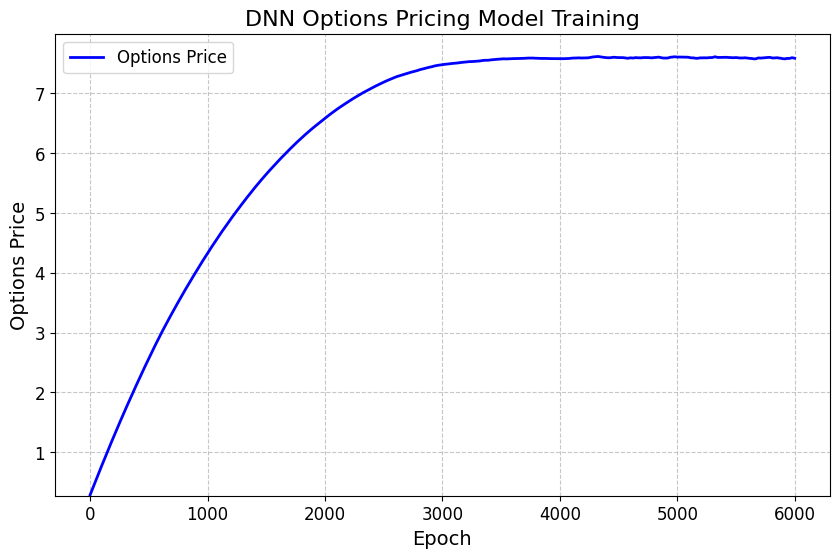

In [337]:
# Create the plot with specific size and higher resolution
fig, ax = plt.subplots(figsize=(10, 6))  # Adjust the figure size as needed

# Extract the number of epochs from the history length
xrange = range(len(history))

# Plot the third element from each entry in 'history'
ax.plot(xrange, [loss[2] for loss in history], 'b-', label='Options Price', linewidth=2)
fig.patch.set_facecolor('white')
ax.set_facecolor('white')

# Add labels and title with customized font size
ax.set_xlabel('Epoch', fontsize=14)
ax.set_ylabel('Options Price', fontsize=14)
ax.set_title('DNN Options Pricing Model Training', fontsize=16)

# Add a grid for better readability
ax.grid(True, linestyle='--', alpha=0.7)

# Add a legend with custom position
ax.legend(loc='upper left', fontsize=12)

# Customize tick parameters for better readability
ax.tick_params(axis='both', which='major', labelsize=12)

# Optionally, set limits for the y-axis to provide more context
ax.set_ylim([min([loss[2] for loss in history]) * 0.95, max([loss[2] for loss in history]) * 1.05])

# Display the plot
plt.show()

In [327]:
# Save the model for future use
model.save('high_dim_black_scholes_bsde.kerasV2.keras')

In [ ]:
# Load the model for marking
load_model = tf.keras.models.load_model('high_dim_black_scholes_bsdeV2.keras')

This code has been adapted from the original author - "https://github.com/Mephistopheles-0/DeepBSDE/blob/main/Jupyter%20version%20(Black-Scholes%20Default%20risk%20Example).ipynb".